In [1]:
original_path="./dataset_original"  ### please enter path to cough dataset
device='cuda' ###please enter device: cuda or cpu

In [2]:
#imports
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import librosa
from pydub import AudioSegment
#from PIL import Image 
import os

#tensorboard
%load_ext tensorboard
from tensorflow import summary
import tensorflow as tf

#pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#directory for saving trained model
if not os.path.exists('./models'):
    os.makedirs('./models')

In [3]:
#set seed
%env CUBLAS_WORKSPACE_CONFIG=:16:8
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)
torch.manual_seed(19)
torch.cuda.manual_seed(19)
np.random.seed(19)

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [4]:
#convert mp3 to wav
pos_path=original_path+"/segmented/pos/"
neg_path=original_path+"/segmented/neg/"

wav_path='./dataset_wav/'

#create directories for wav files
if not os.path.exists(wav_path):
    os.makedirs(wav_path)

#mp3 to wav conversion    
for i in os.listdir(pos_path):
    if i[-8]!='2': ##exclude a patient from the dataset
        AudioSegment.from_mp3(pos_path+i).export(wav_path+i[0:-3]+'wav', format="wav")
for i in os.listdir(neg_path):
    AudioSegment.from_mp3(neg_path+i).export(wav_path+i[0:-3]+'wav', format="wav")        

In [5]:
class spectogram():
    
    def __init__(self, path):
        self.path = path
        
    def __len__(self):
        return len(os.listdir(self.path))

    def __getitem__(self, idx):
        
        y, sr=librosa.load(self.path+os.listdir(self.path)[idx])
        sgram=librosa.feature.melspectrogram(y=y, sr=sr)
        sgram=torch.tensor(sgram).unsqueeze(1).permute(1,0,2)
        
        data=dict()
        data['sgram']=sgram
        
        if os.listdir(self.path)[idx][0]=='p':
            data['class']= "positive"
            data['label']= 1
        else:    
            data['class']= "negative"
            data['label']= 0  
            
        return data

In [6]:
#prepare dataset
dataset= spectogram(wav_path)
L=len(dataset)

#split in train, test, validation
train_set, test_set = \
torch.utils.data.random_split(dataset,[math.ceil(L*0.8),int(L*0.2)])

print(len(train_set),'+', len(test_set),'=',L)

#dataloader
batch_size=16

#dataset_dl=DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=1, shuffle=False)


93 + 23 = 116


In [7]:
#view the dataloader
sample=next(iter(train_dl))
print(sample['sgram'].shape) # batch_size, channels, height, width
print(sample['label'])# 1 or 0

torch.Size([16, 1, 128, 69])
tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1])


In [8]:
#CNNs
class Model(nn.Module):
    def __init__(self, height=128, width=69, dim_output=2):
        super(Model, self).__init__()
        
        self.H=height
        self.W=width
        self.output=dim_output
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation = nn.ReLU()
        self.dropout= nn.Dropout(p=0.5) 
        self.bn1= nn.BatchNorm2d(32) 
        self.bn2= nn.BatchNorm2d(64)
        self.bn3= nn.BatchNorm2d(128)
        
        #convolutions
        self.conv1 = nn.Conv2d( 1,  32,kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32,  64,kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=1)
        
        #fully connected
        self.fc1 = nn.Linear(128*(self.H//8)*(self.W//8),128) 
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,self.output)
        
        #sequential
        self.layer1=nn.Sequential(self.conv1, self.bn1, self.max_pool, self.activation)
        self.layer2=nn.Sequential(self.conv2, self.bn2, self.max_pool, self.activation)
        self.layer3=nn.Sequential(self.conv3, self.bn3, self.max_pool, self.activation)
        self.layer4=nn.Sequential(self.fc1, self.activation, self.dropout)
        self.layer5=nn.Sequential(self.fc2, self.activation, self.dropout)
        
    def forward(self, img):
        
        out=self.layer3(self.layer2(self.layer1(img)))
        
        ###flattening
        batch_size =img.shape[0]
        out=out.view(batch_size, -1)
        
        out=self.fc3(self.layer5(self.layer4(out)))
       
        return out           

In [9]:
#model and optimizer
model = Model()
model = model.to(device) 

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

#print(model)
sample_out=model(sample['sgram'].to(device)) 
sample_out.shape

torch.Size([16, 2])

In [10]:
#train function
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define input and output
    img = sample['sgram'].float().to(device) 
    label = sample['label'].long().to(device)
  
    # get the prediction
    pred = model(img) 

    pred_loss = criterion(pred, label)
    
    # regularization loss
    reg_loss= 0.0
    for p in model.parameters():
        if p.requires_grad: # if p is a trainable parameter
            reg_loss+=torch.norm(p,2)

    total_loss= pred_loss + 1e-6 * reg_loss
    
    num_correct = sum(torch.argmax(pred, dim=1) == label)
    
    #one step of training
    total_loss.backward()
    optimizer.step()

    return total_loss.item(), num_correct.item()

In [11]:
#test function
def test(model, sample): 
    model.eval()

    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad(): 
        
        img = sample['sgram'].float().to(device)
        label = sample['label'].long().to(device)
       
        # get the prediction
        pred = model(img)
        
        pred_loss = criterion(pred, label)
        
        # regularization loss
        reg_loss= 0.0
        for p in model.parameters():
            if p.requires_grad: # if p is a trainable parameter
                reg_loss+=torch.norm(p,2)

        total_loss= pred_loss + 1e-6 * reg_loss
        
        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return total_loss.item(), num_correct.item()

In [12]:
#prepare tensorboard
train_log_dir = './models/runs_cnn/train'
train_summary_writer = summary.create_file_writer(train_log_dir)
test_log_dir = './models/runs_cnn/test'
test_summary_writer = summary.create_file_writer(test_log_dir)

In [13]:
##################################start training and validating#####################################################
max_epoch = 23
tmp_path = './models/temp.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    #########TEMPORARY################################
    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
       
    ##################################################

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dl)) as pbar:
        for sample in train_dl:            
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dl) 
            train_accu += num_correct / len(train_set)
            pbar.update(1)
            
    ### Write the current loss and accuracy to the Tensorboard
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)                
        tf.summary.scalar('accuracy', train_accu, step=epoch)         
         
    ###############TEMPORARY#######################################
    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        
    }
    torch.save(checkpoint, tmp_path)
    ###################################################################
    
    ### Validate Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(test_dl)) as pbar:
        for idx, sample in enumerate(test_dl): 
            curr_loss, num_correct = test(model, sample)
            test_loss += curr_loss / len(test_dl)
            test_accu += num_correct / len(test_set)
            pbar.update(1)
    
    ### Write the current loss and accuracy to the Tensorboard
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_accu, step=epoch)    
    
        
    print(train_accu, test_accu)  
    
os.remove(tmp_path)    


0.6021505376344086 0.6956521739130432



0.5913978494623655 0.8260869565217388



0.6021505376344086 0.8260869565217388



0.6236559139784945 0.7391304347826084



0.6236559139784947 0.8260869565217388



0.6881720430107527 0.6956521739130432



0.6881720430107527 0.869565217391304



0.6559139784946237 0.8260869565217388



0.6451612903225806 0.8260869565217388



0.6451612903225807 0.7826086956521736



0.8279569892473118 0.8260869565217388



0.7741935483870968 0.9565217391304344



0.8279569892473118 0.9130434782608692



0.7526881720430108 0.9130434782608692



0.8602150537634408 0.9130434782608692



0.8494623655913979 0.8260869565217388



0.8817204301075268 0.8260869565217388



0.8279569892473118 0.8260869565217388



0.8709677419354839 0.9130434782608692



0.9354838709677419 0.8260869565217388



0.8602150537634408 0.7391304347826084



0.9784946236559139 0.7391304347826084



0.9462365591397851 0.6956521739130432



In [14]:
def freq_domain(sample,sr):
    L=sample.shape[0]
    Y=np.fft.fft(sample,sr)
    P2 = abs(Y/L)
    P1 = P2[0:sr//2+1]
    P1[1:-1] = 2*P1[1:-1]
    return P1    

In [15]:
Y_pos=Y_neg=p=n=0

for j in os.listdir(wav_path):
    y,sr=librosa.load(wav_path+j)
    L=y.shape[0]
    if j[0]=='p':
        Y_pos+=freq_domain(y,sr)
        p+=1
    else:
        Y_neg+=freq_domain(y,sr)
        n+=1
Y_pos/=p
Y_neg/=n

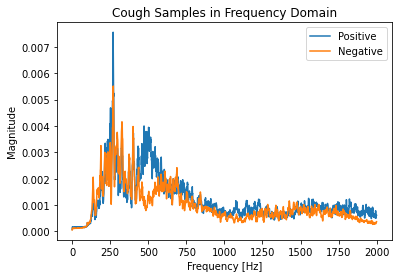

In [16]:
plt.title('Cough Samples in Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.plot(Y_pos[0:2000],label='Positive')
plt.plot(Y_neg[0:2000],label='Negative')
plt.legend()

In [17]:
f1=450
f2=550

In [18]:
class fft():
    
    def __init__(self, path):
        self.path = path
        
    def __len__(self):
        return len(os.listdir(self.path))

    def __getitem__(self, idx):
        
        y,sr=librosa.load(self.path+os.listdir(self.path)[idx])
        
        y_freq=freq_domain(y,sr)
        Y=y_freq[f1:f2]
        #Y=torch.tensor(Y).unsqueeze(1).permute(1,0).float()
 
        data=dict()
        data['sgram']=Y
        
        if os.listdir(self.path)[idx][0]=='p':
            data['class']= "positive"
            data['label']= 1
        else:    
            data['class']= "negative"
            data['label']= 0  
            
        return data

In [19]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)
torch.manual_seed(19)
torch.cuda.manual_seed(19)
np.random.seed(19)

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [20]:
#prepare dataset
fft_dataset= fft(wav_path)
fft_L=len(fft_dataset)

#split in train, test, validation
fft_train_set, fft_test_set = \
torch.utils.data.random_split(fft_dataset,[math.ceil(fft_L*0.8),int(fft_L*0.2)])

print(len(fft_train_set),'+', len(fft_test_set),'=',fft_L)

#dataloader
batch_size=16

fft_dataset_dl=DataLoader(fft_dataset, batch_size=batch_size, shuffle=True)
fft_train_dl = DataLoader(fft_train_set, batch_size=batch_size, shuffle=True)
fft_test_dl = DataLoader(fft_test_set, batch_size=1, shuffle=False)


93 + 23 = 116


In [21]:
#view the dataloader
fft_sample=next(iter(fft_train_dl))
print(fft_sample['sgram'].shape) # batch_size, channels, height, width
print(fft_sample['label'])# 1 or 0

torch.Size([16, 100])
tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1])


In [22]:
#logistic regression
class Model2(nn.Module):
    def __init__(self, L=f2-f1, dim_output=2):
        super(Model2, self).__init__()
        self.dim_output=dim_output
        self.L=L

        #fully connected
        self.layer = nn.Linear(self.L, self.dim_output)
        
    def forward(self, img):
        
        out=self.layer(img)
        return out            

In [23]:
#model and optimizer
model2 = Model2()
model2 = model2.to(device) 

optimizer2 = optim.Adam(model2.parameters(), lr=0.1, weight_decay=1e-6)

#print(model)
#sample_out=model2(fft_sample['sgram'].to(device)) 
#sample_out.shape

In [24]:
#prepare tensorboard
train_log_dir = './models/runs_log/train'
train_summary_writer = summary.create_file_writer(train_log_dir)
test_log_dir = './models/runs_log/test'
test_summary_writer = summary.create_file_writer(test_log_dir)

In [25]:
##################################start training and validating#####################################################
max_epoch = 23
tmp_path = './models/temp.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    #########TEMPORARY################################
    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model2.load_state_dict(checkpoint['model2_state_dict'])
        optimizer2.load_state_dict(checkpoint['optimizer2_state_dict'])
       
    ##################################################

    # Iterate over the train_dataloader
    with tqdm(total=len(fft_train_dl)) as pbar:
        for sample in fft_train_dl:            
            curr_loss, num_correct = train(model2, optimizer2, sample)
            train_loss += curr_loss / len(fft_train_dl) 
            train_accu += num_correct / len(fft_train_set)
            pbar.update(1)
    
    
    ### Write the current loss and accuracy to the Tensorboard
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)                
        tf.summary.scalar('accuracy', train_accu, step=epoch)         
         
    ###############TEMPORARY#######################################
    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model2_state_dict': model2.state_dict(),
        'optimizer2_state_dict': optimizer2.state_dict(),
        
    }
    torch.save(checkpoint, tmp_path)
    ###################################################################
    
    ### Validate Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(fft_test_dl)) as pbar:
        for idx, sample in enumerate(fft_test_dl): 
            curr_loss, num_correct = test(model2, sample)
            test_loss += curr_loss / len(fft_test_dl)
            test_accu += num_correct / len(fft_test_set)
            pbar.update(1)
    
    ### Write the current loss and accuracy to the Tensorboard
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_accu, step=epoch)    
        
    print(train_accu, test_accu)     

os.remove(tmp_path)


0.6129032258064516 0.6956521739130432



0.6236559139784946 0.8260869565217388



0.7526881720430108 0.869565217391304



0.7311827956989247 0.9130434782608692



0.7526881720430108 0.869565217391304



0.7526881720430108 0.869565217391304



0.7634408602150538 0.9130434782608692



0.7204301075268817 0.9565217391304344



0.7204301075268817 0.9565217391304344



0.7204301075268817 0.9130434782608692



0.7311827956989247 0.9565217391304344



0.7311827956989247 0.9565217391304344



0.7096774193548387 0.9130434782608692



0.7204301075268817 0.9565217391304344



0.7311827956989247 0.9565217391304344



0.7204301075268816 0.9130434782608692



0.7204301075268817 0.9565217391304344



0.7311827956989247 0.9130434782608692



0.7204301075268817 0.9130434782608692



0.7311827956989247 0.9130434782608692



0.7096774193548387 0.9130434782608692



0.7311827956989247 0.9565217391304344



0.7204301075268817 0.9565217391304344



In [26]:
####Evaluation for model 1
accuracy=tp=tn=fn=fp=p=n=0
for i in test_set:
    x=model(torch.tensor(i['sgram']).float().to(device).unsqueeze(1))[0][0].item()
    y=model(torch.tensor(i['sgram']).float().to(device).unsqueeze(1))[0][1].item()
    
    if x>y:
        pred=0
    else:
        pred=1
    
    if i['label']== 1:
        p+=1
    else:
        n+=1
        
    if i['label']==pred:  
        accuracy += 1
        if pred == 1:
            tp += 1
        else:
            tn += 1    
    else:
        if pred == 1:
            fp += 1
        else:
            fn += 1
        
accuracy /= len(fft_test_set)

print('Accuracy =', accuracy)
print('Sensitivity/ TPR =', tp/p)
print('Specifity/ TNR =', tn/n)
print('Balanced Accuracy =', (tp/p + tn/n)/2)

print('tp:',tp, ' tn:',tn, ' fp:',fp, ' fn:', fn)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Accuracy = 0.6956521739130435
Sensitivity/ TPR = 0.42857142857142855
Specifity/ TNR = 0.8125
Balanced Accuracy = 0.6205357142857143
tp: 3  tn: 13  fp: 3  fn: 4


In [27]:
####Evaluation for model 2
accuracy=tp=tn=fn=fp=p=n=0
for i in fft_test_set:
    x=model2(torch.tensor(i['sgram']).float().to(device))[0].item()
    y=model2(torch.tensor(i['sgram']).float().to(device))[1].item()
    
    if x>y:
        pred=0
    else:
        pred=1
    
    if i['label']== 1:
        p+=1
    else:
        n+=1
        
    if i['label']==pred:  
        accuracy += 1
        if pred == 1:
            tp += 1
        else:
            tn += 1    
    else:
        if pred == 1:
            fp += 1
        else:
            fn += 1
        
accuracy /= len(fft_test_set)

print('Accuracy =', accuracy)
print('Sensitivity =', tp/p)
print('Specifity =', tn/n)
print('Balanced Accuracy =', (tp/p + tn/n)/2)

print('tp:',tp, ' tn:',tn, ' fp:',fp, ' fn:', fn)

Accuracy = 0.9565217391304348
Sensitivity = 0.8571428571428571
Specifity = 1.0
Balanced Accuracy = 0.9285714285714286
tp: 6  tn: 16  fp: 0  fn: 1
